# COURSERA CAPSTONE FINAL PROJECT, WEEKS 4 & 5

## Find the best location to open a fitness nutrition shop in a shopping mall in Toronto

## Import required libraries

In [89]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules
from matplotlib import pyplot as plt

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

### Import and explore Toronto postalcode areas

In [90]:
# import data frame
df=pd.read_csv('Toronto_neighborhoods_WithGeospacial.csv')
df.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [91]:
print('The dataframe has {} boroughs and {} Neighborhood.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 Neighborhood.


#### Use geopy library to get the latitude and longitude values of Toronto.

In [92]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with Neighborhoods superimposed on top.

In [93]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'],\
                                           df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## Define Foursquare Credentials and Version

In [94]:
# Note that these credentials are saved in Credentials.csv which is not shared on github
Cred_data=pd.read_csv('Credentials.csv')
CLIENT_ID='5LJOJSOHCGXQDQPSJGY3GRZIHB2EJWJEL2ANTCZOUV0FIL5L'#Cred_data['CLIENT_ID'][0]
CLIENT_SECRET='TDF2G1JALYUMVXS0KRN0E4GTOV2WGPW041IBZVDKYJSGVQ43'#Cred_data['CLIENT_SECRET'][0]
VERSION=Cred_data['VERSION'][0]
LIMIT=Cred_data['LIMIT'][0]

**Fetch Foursquare Venue Category Hierarchy**

In [95]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [96]:
with open('category_results.json', 'w') as f:
    json.dump(category_results, f)

In [97]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [98]:
category_list = category_results['response']['categories']
len(category_list)

10

In [99]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


In [100]:
Sport_ID='4d4b7105d754a06377d81259'
Shop_ID='4d4b7105d754a06378d81259'

**_Outdoors & Recreation_ & It's Sub-Categories**

Let's create a function to return a dictionary with Ids' & Names of _Outdoors & Recreation_ & It's Sub-Categories.

In [101]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [102]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = Sport_ID)

In [103]:
category_dict

{'4d4b7105d754a06377d81259': 'Outdoors & Recreation',
 '4f4528bc4b90abdf24c9de85': 'Athletics & Sports',
 '52e81612bcbc57f1066b7a2b': 'Badminton Court',
 '4bf58dd8d48988d1e8941735': 'Baseball Field',
 '4bf58dd8d48988d1e1941735': 'Basketball Court',
 '52e81612bcbc57f1066b7a2f': 'Bowling Green',
 '56aa371be4b08b9a8d57351a': 'Curling Ice',
 '4bf58dd8d48988d1e6941735': 'Golf Course',
 '58daa1558bbb0b01f18ec1b0': 'Golf Driving Range',
 '4bf58dd8d48988d175941735': 'Gym / Fitness Center',
 '52f2ab2ebcbc57f1066b8b47': 'Boxing Gym',
 '503289d391d4c4b30a586d6a': 'Climbing Gym',
 '52f2ab2ebcbc57f1066b8b49': 'Cycle Studio',
 '4bf58dd8d48988d105941735': 'Gym Pool',
 '52f2ab2ebcbc57f1066b8b48': 'Gymnastics Gym',
 '4bf58dd8d48988d176941735': 'Gym',
 '4bf58dd8d48988d101941735': 'Martial Arts Dojo',
 '58daa1558bbb0b01f18ec203': 'Outdoor Gym',
 '5744ccdfe4b0c0459246b4b2': 'Pilates Studio',
 '4bf58dd8d48988d106941735': 'Track',
 '590a0744340a5803fd8508c3': 'Weight Loss Center',
 '4bf58dd8d48988d102941735

Now, we have all the categories in _Outdooes and recreation_ with their id's.

#### Explore the first Neighborhood to understand the results of GET Request

Get the Neighborhood's name.

In [104]:
df.loc[0, 'Neighborhood']

'Parkwoods'

Get the Neighborhood's latitude and longitude values.

In [105]:
neighborhood_latitude = df.loc[0, 'Latitude'] # Neighborhood area latitude value
neighborhood_longitude = df.loc[0, 'Longitude'] # Neighborhood area longitude value

neighborhood_name = df.loc[0, 'Postalcode'] # postalcode name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of M3A are 43.7532586, -79.3296565.


#### Now, let's get the _Sport & Recreation_ that is in this neighborhood within a radius of 500 meters.

First, let's create the GET request URL to search for Venue with requested _Category ID_

In [106]:
LIMIT = 10 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = Sport_ID # category ID for "sport and recreation"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=5LJOJSOHCGXQDQPSJGY3GRZIHB2EJWJEL2ANTCZOUV0FIL5L&client_secret=TDF2G1JALYUMVXS0KRN0E4GTOV2WGPW041IBZVDKYJSGVQ43&v=20180604&ll=43.7532586,-79.3296565&radius=500&categoryId=4d4b7105d754a06377d81259&limit=10'

Send the GET request and examine the resutls

In [107]:
results = requests.get(url).json()

In [108]:
results['response']['venues'][0]

{'id': '4e8d9dcdd5fbbbb6b3003c7b',
 'name': 'Brookbanks Park',
 'location': {'address': 'Toronto',
  'lat': 43.751976046055574,
  'lng': -79.33214044722958,
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.751976046055574,
    'lng': -79.33214044722958}],
  'distance': 245,
  'cc': 'CA',
  'city': 'Toronto',
  'state': 'ON',
  'country': 'Canada',
  'formattedAddress': ['Toronto', 'Toronto ON', 'Canada']},
 'categories': [{'id': '4bf58dd8d48988d163941735',
   'name': 'Park',
   'pluralName': 'Parks',
   'shortName': 'Park',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_',
    'suffix': '.png'},
   'primary': True}],
 'referralId': 'v-1589528344',
 'hasPerk': False}

The category name of the venue **'Brookbanks Park'** is **'Parks'**.

As, our aim is to segment the neighborhoods of Toronto with respect to the _Sport & Recreation_ in its vicinity. We need to proceed further to fetch this data from all the 103 neighborhoods' venues.

#### Let's create a function to repeat the following process to all the postalcode areas in Toronto:
* Loop through postalcodes
    * Create the API request URL with radius=500, LIMIT=100
    * Make the GET request
    * For each postalcode, return only relevant information for each nearby venue
    * Append all nearby venues to a list
* Unfold the list & append it to dataframe being returned

In [109]:
def getNearbyVenues(ID, names, latitudes, longitudes, radius=1500, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            ID, # category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

**Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.**

In [110]:
import pickle # to serialize and deserialize a Python object structure

# get all sport venues
try:
    with open('Toronto_venues_sport.pkl', 'rb') as f:
        Toronto_venues_sport = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues_sport = getNearbyVenues(ID=Sport_ID, names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_venues_sport.pkl', 'wb') as f:
        pickle.dump(Toronto_venues_sport, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


In [111]:
# get all shop venues
try:
    with open('Toronto_venues_shop.pkl', 'rb') as f:
        Toronto_venues_shop = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues_shop = getNearbyVenues(ID=Shop_ID, names=df['Neighborhood'],
                                        latitudes=df['Latitude'],
                                        longitudes=df['Longitude']
                                       )
    with open('Toronto_venues_shop.pkl', 'wb') as f:
        pickle.dump(Toronto_venues_shop, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


## 3. Analysis & Machine Learning

#### Let's find out how many unique categories can be curated from all the returned sport venues

In [112]:
print('There are {} uniques categories.'.format(len(Toronto_venues_sport['Venue Category'].unique())))
Toronto_venues_sport.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 105 uniques categories.


Venue Category
Park                                        1005
Gym                                          425
Gym / Fitness Center                         257
Playground                                   237
Other Great Outdoors                         184
Athletics & Sports                           126
Pool                                         124
Garden                                       123
Trail                                        101
Skating Rink                                 100
Dog Run                                       92
Yoga Studio                                   89
Bridge                                        79
Martial Arts Dojo                             77
Baseball Field                                71
Tennis Court                                  70
Plaza                                         65
Harbor / Marina                               62
Field                                         51
Scenic Lookout                                46
Socce

In [113]:
# manually create a list of desired sport related categories (> 20 venues)
sport_categories = ['Gym','Gym / Fitness Center','Gym Pool']

Revise the results to keep only venues in the list of sport categories

In [114]:
Toronto_venues_sport = Toronto_venues_sport[Toronto_venues_sport['Venue Category'].isin(sport_categories)].reset_index()
Toronto_venues_sport.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,Parkwoods,43.753259,-79.329656,GoodLife Fitness North York Victoria Terrace,43.742128,-79.314590,Gym
1,13,Parkwoods,43.753259,-79.329656,Orangetheory Fitness,43.754577,-79.351034,Gym / Fitness Center
2,22,Parkwoods,43.753259,-79.329656,WestinWORKOUT Gym,43.756902,-79.350656,Gym
3,30,Parkwoods,43.753259,-79.329656,The Cloisters Gym,43.741575,-79.328823,Gym
4,31,Parkwoods,43.753259,-79.329656,Above Threshold,43.755458,-79.347519,Gym


#### Let's find out how many unique categories can be curated from all the returned shop venues

In [115]:
print('There are {} uniques categories.'.format(len(Toronto_venues_shop['Venue Category'].unique())))
Toronto_venues_shop.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 161 uniques categories.


Venue Category
Grocery Store                               469
Pharmacy                                    350
Gas Station                                 228
Bank                                        199
Supermarket                                 187
Convenience Store                           178
Shopping Mall                               174
Liquor Store                                139
Automotive Shop                             138
Salon / Barbershop                          135
Discount Store                              116
Hardware Store                              101
Miscellaneous Shop                           84
Electronics Store                            75
Furniture / Home Store                       72
Clothing Store                               56
Beer Store                                   46
Flower Shop                                  46
Pet Store                                    41
Butcher                                      41
Auto Dealership          

In [116]:
# manually create a list of desired shop related categories
shop_categories = ['Shopping Mall','Shopping Plaza','Supplement Shop']

Revise the results to keep only venues in the list of sport categories

In [117]:
Toronto_venues_shop = Toronto_venues_shop[Toronto_venues_shop['Venue Category'].isin(shop_categories)].reset_index()
Toronto_venues_shop.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,15,Parkwoods,43.753259,-79.329656,Yorkdon Mews,43.755165,-79.348470,Shopping Plaza
1,23,Parkwoods,43.753259,-79.329656,Parkway Mall,43.757585,-79.312377,Shopping Mall
2,24,Parkwoods,43.753259,-79.329656,Parkwoods Village Centre,43.760735,-79.324873,Shopping Mall
3,26,Parkwoods,43.753259,-79.329656,Donwood Plaza,43.745369,-79.325435,Shopping Mall
4,27,Parkwoods,43.753259,-79.329656,Victoria Terrace,43.742247,-79.312895,Shopping Mall


### Analyze Each neighborhood

In [118]:
# one hot encoding the sport venues
Toronto_onehot_sport = pd.get_dummies(Toronto_venues_sport[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot_sport.head()

,Gym,Gym / Fitness Center,Gym Pool
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


In [119]:
# one hot encoding the shopping venues
Toronto_onehot_shop = pd.get_dummies(Toronto_venues_shop[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot_shop.head()

,Shopping Mall,Shopping Plaza,Supplement Shop
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [120]:
print(Toronto_onehot_sport.shape)
print(Toronto_onehot_shop.shape)

(695, 3)
(201, 3)


In [121]:
# add Neighborhood column back to dataframe
Toronto_onehot_sport['Neighborhood'] = Toronto_venues_sport['Neighborhood'] 
Neighborhood = Toronto_onehot_sport['Neighborhood']
Toronto_onehot_sport.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot_sport.insert(0, 'Neighborhood', Neighborhood)
Toronto_onehot_shop['Neighborhood'] = Toronto_venues_shop['Neighborhood'] 
Neighborhood = Toronto_onehot_shop['Neighborhood']
Toronto_onehot_shop.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot_shop.insert(0, 'Neighborhood', Neighborhood)

Let's count venues of each category in each neighborhood

In [122]:
venue_counts_sport= Toronto_onehot_sport.groupby('Neighborhood').sum()
venue_counts_sport.head()

,Gym,Gym / Fitness Center,Gym Pool
Neighborhood,,,
Agincourt,2,5,0
"Alderwood, Long Branch",2,4,0
"Bathurst Manor, Wilson Heights, Downsview North",3,4,1
"Bedford Park, Lawrence Manor East",8,3,0
Berczy Park,4,2,0


Let's find out the top 10 sport categories in Toronto

In [123]:
venue_counts_described_sport = venue_counts_sport.describe().transpose()

In [124]:
venue_top10_sport = venue_counts_described_sport.sort_values('max', ascending=False)[0:10]
venue_top10_sport

,count,mean,std,min,25%,50%,75%,max
Gym,97.0,4.381443,2.759239,0.0,2.0,4.0,6.0,14.0
Gym / Fitness Center,97.0,2.649485,2.086870,0.0,1.0,2.0,4.0,12.0
Gym Pool,97.0,0.134021,0.342444,0.0,0.0,0.0,0.0,1.0


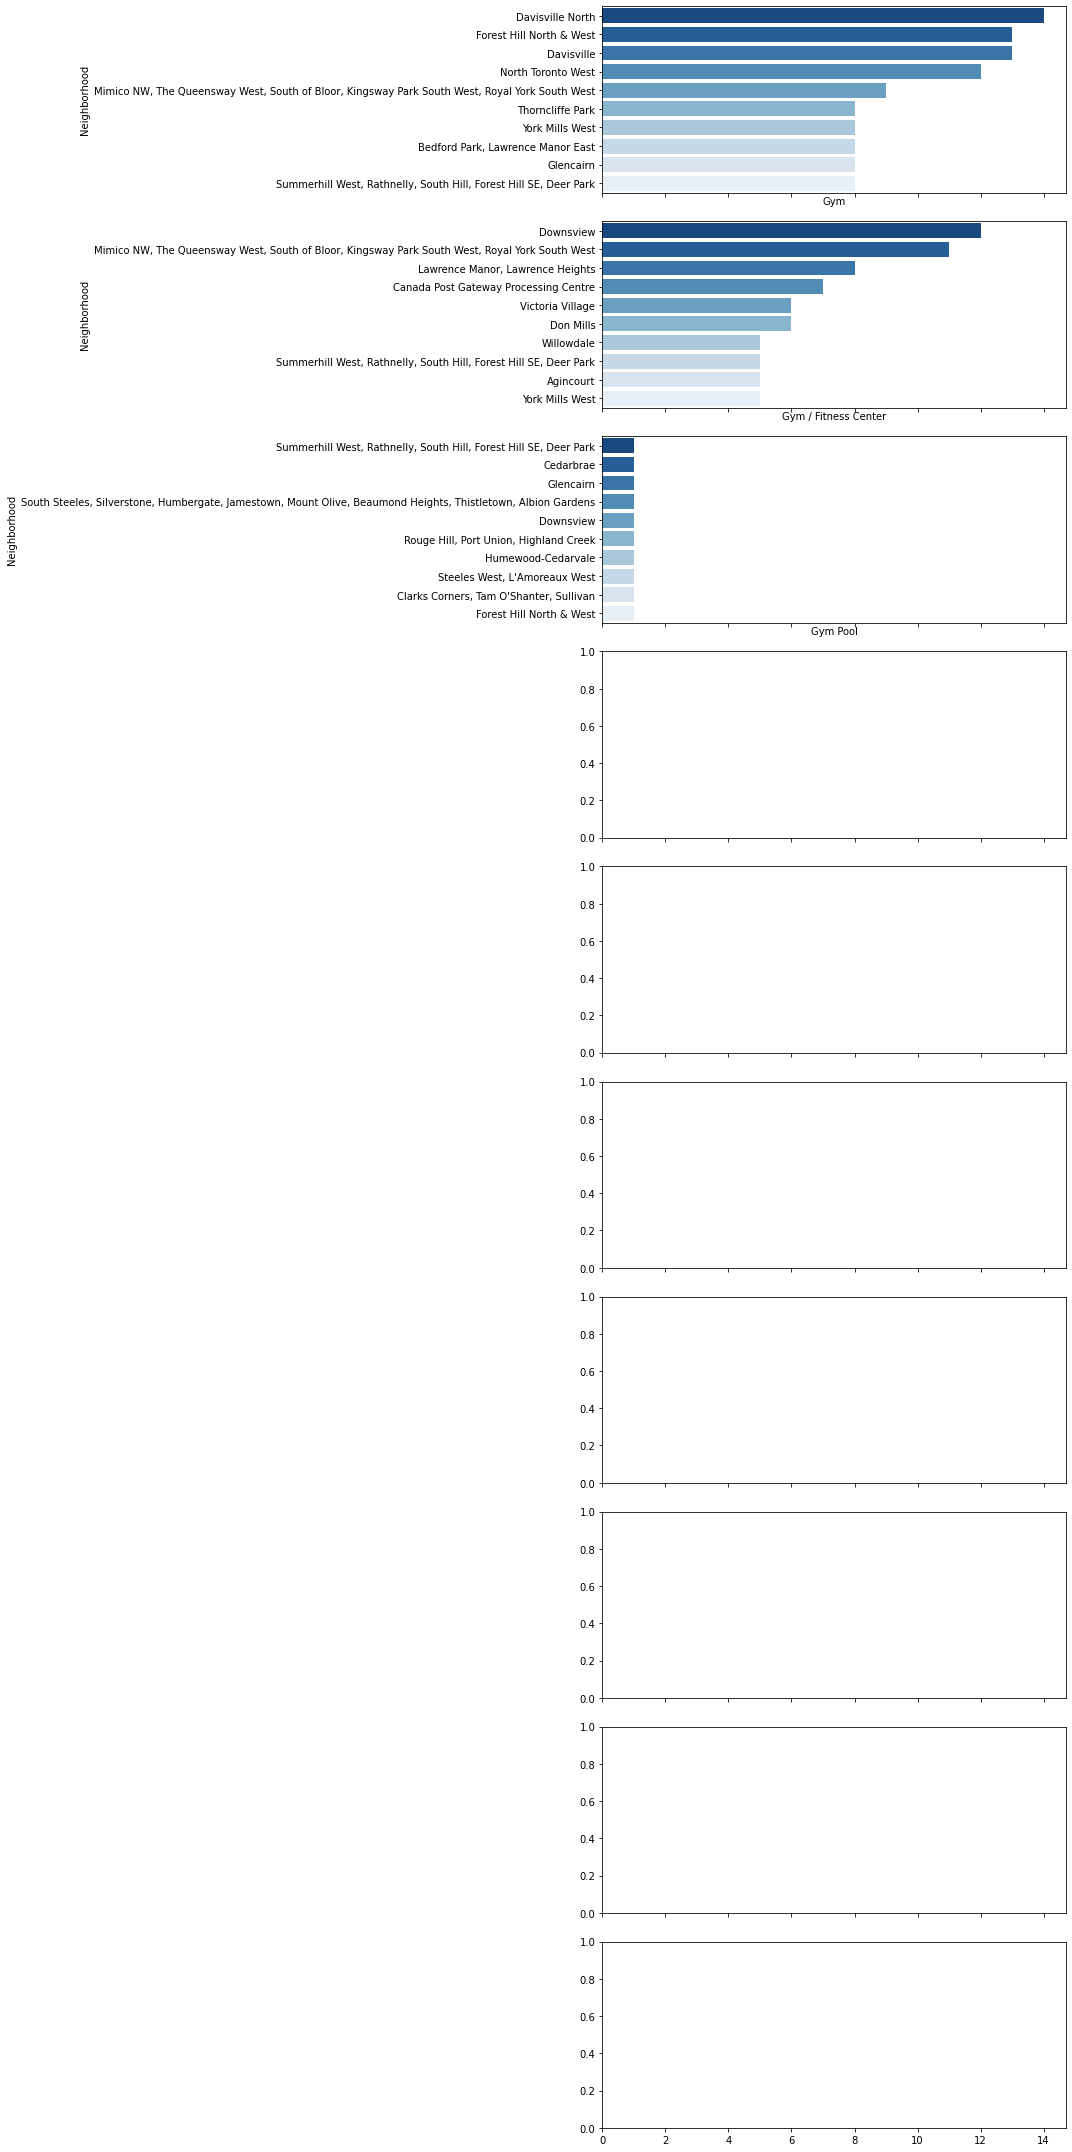

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(10, 1, figsize=(15,30), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_sport.index.values.tolist()):
    data = venue_counts_sport[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [126]:
Toronto_grouped_sport = Toronto_onehot_sport.groupby('Neighborhood').mean().reset_index()
Toronto_grouped_sport.head()

,Neighborhood,Gym,Gym / Fitness Center,Gym Pool
0,Agincourt,0.285714,0.714286,0.000
1,"Alderwood, Long Branch",0.333333,0.666667,0.000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.375000,0.500000,0.125
3,"Bedford Park, Lawrence Manor East",0.727273,0.272727,0.000
4,Berczy Park,0.666667,0.333333,0.000


#### Let's write a function to sort the venues in descending order.

In [127]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [128]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))  
        
columns

['Neighborhood',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue']

In [129]:
# create a new dataframe
neighborhoods_venues_sorted_sport = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_sport['Neighborhood'] = Toronto_grouped_sport['Neighborhood']
for ind in np.arange(Toronto_grouped_sport.shape[0]):
    neighborhoods_venues_sorted_sport.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped_sport.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_sport.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agincourt,Gym / Fitness Center,Gym,Gym Pool
1,"Alderwood, Long Branch",Gym / Fitness Center,Gym,Gym Pool
2,"Bathurst Manor, Wilson Heights, Downsview North",Gym / Fitness Center,Gym,Gym Pool
3,"Bedford Park, Lawrence Manor East",Gym,Gym / Fitness Center,Gym Pool
4,Berczy Park,Gym,Gym / Fitness Center,Gym Pool


### Cluster Neighborhoods

Create a data frame with the total count of sport venues for each neighborhood

In [130]:
Toronto_grouped_sport_count= Toronto_onehot_sport.groupby('Neighborhood').sum().reset_index()
# create a new column which has the sum of all columns for each row
Toronto_grouped_sport_count['#sport venues']=Toronto_grouped_sport_count.sum(axis=1)
# drop all other columns
Toronto_grouped_sport_count.drop(sport_categories,axis=1,inplace=True)
Toronto_grouped_sport_count.head()

,Neighborhood,#sport venues
0,Agincourt,7
1,"Alderwood, Long Branch",6
2,"Bathurst Manor, Wilson Heights, Downsview North",8
3,"Bedford Park, Lawrence Manor East",11
4,Berczy Park,6


Create a data frame with the total count of shopping venues for each neighborhood

In [131]:
Toronto_grouped_shop_count= Toronto_onehot_shop[['Neighborhood','Shopping Mall', 'Shopping Plaza']].groupby('Neighborhood').sum().reset_index()
# create a new column which has the sum of all columns for each row
Toronto_grouped_shop_count['#shopping venues']=Toronto_grouped_shop_count.sum(axis=1)
# drop all other columns
Toronto_grouped_shop_count.drop(['Shopping Mall', 'Shopping Plaza'],axis=1,inplace=True)
Toronto_grouped_shop_count.head()

,Neighborhood,#shopping venues
0,Agincourt,5
1,"Alderwood, Long Branch",3
2,"Bathurst Manor, Wilson Heights, Downsview North",1
3,Bayview Village,4
4,Berczy Park,2


In [152]:
# create a new data frame with only Sporting Goods Shop column and groupby Neighborhood
Toronto_grouped_SportGoodsShop_count= Toronto_onehot_shop[['Neighborhood','Supplement Shop']].groupby('Neighborhood').sum().reset_index()
# create a new column which has the sum of all columns for each row
Toronto_grouped_SportGoodsShop_count.head()

,Neighborhood,Supplement Shop
0,Agincourt,1
1,"Alderwood, Long Branch",0
2,"Bathurst Manor, Wilson Heights, Downsview North",0
3,Bayview Village,0
4,Berczy Park,0


Combine the previous data frames

In [153]:
#Toronto_grouped_sport.merge(Toronto_grouped_shop, on='Neighborhood')
Toronto_merged_sport_shop=Toronto_grouped_sport_count.merge(Toronto_grouped_shop_count, on='Neighborhood').merge(Toronto_grouped_SportGoodsShop_count, on='Neighborhood')
Toronto_merged_sport_shop.head()

,Neighborhood,#sport venues,#shopping venues,Supplement Shop
0,Agincourt,7,5,1
1,"Alderwood, Long Branch",6,3,0
2,"Bathurst Manor, Wilson Heights, Downsview North",8,1,0
3,Berczy Park,6,2,0
4,"Birch Cliff, Cliffside West",5,1,0


Remove the neighborhoods with one or more sporting goods shop from the dataframe

In [155]:
Toronto_merged_sport_shop.drop(Toronto_merged_sport_shop[Toronto_merged_sport_shop['Supplement Shop']!=0].index,inplace=True)
# drop the 'Sporting Goods Shop' column
Toronto_merged_sport_shop.drop('Supplement Shop',axis=1,inplace=True)
Toronto_merged_sport_shop.head()

,Neighborhood,#sport venues,#shopping venues
1,"Alderwood, Long Branch",6,3
2,"Bathurst Manor, Wilson Heights, Downsview North",8,1
3,Berczy Park,6,2
4,"Birch Cliff, Cliffside West",5,1
6,Business reply mail Processing Centre,7,2


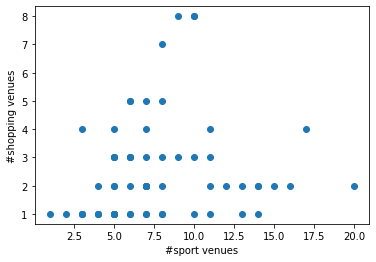

In [156]:
# visualize the data with a scatter plot
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.xlabel("#sport venues")
plt.ylabel("#shopping venues")
plt.show()

Run *k*-means to count Neighborhoods for each cluster label for variable cluster size

In [157]:
Toronto_grouped_clustering = Toronto_merged_sport_shop.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

**The Elbow Method** - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [158]:
sum_of_squared_distances = []
K = range(2,20)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(Toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

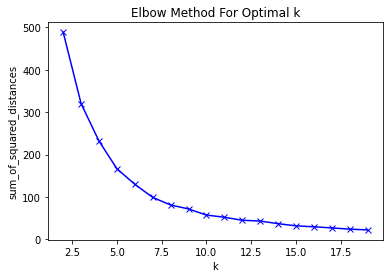

In [159]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

**The Silhouette Method** - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [160]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,20)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(Toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(Toronto_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

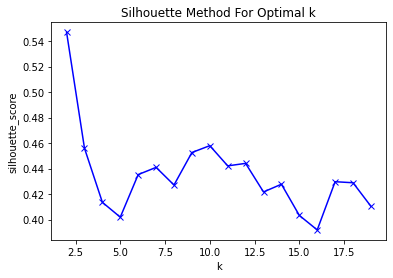

In [161]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [162]:
pd.DataFrame({'Sil':sil,'ksil':K_sil}).head(15)

,Sil,ksil
0,0.546856,2
1,0.455974,3
2,0.413580,4
3,0.401939,5
4,0.435314,6
5,0.440957,7
6,0.427148,8
7,0.452612,9
8,0.457966,10
9,0.442145,11


### Let's set number of clusters = 6

In [163]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(Toronto_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({2: 17, 4: 15, 0: 13, 1: 12, 3: 4, 5: 4})


Let's create a new dataframe that includes the cluster as well as the neighborhood information

In [164]:
# add clustering labels
try:
    Toronto_merged_sport_shop.drop('Cluster Labels', axis=1)
except:
    Toronto_merged_sport_shop.insert(0, 'Cluster Labels', kmeans.labels_)

In [165]:
Toronto_merged_sport_shop.head()

,Cluster Labels,Neighborhood,#sport venues,#shopping venues
1,0,"Alderwood, Long Branch",6,3
2,4,"Bathurst Manor, Wilson Heights, Downsview North",8,1
3,4,Berczy Park,6,2
4,2,"Birch Cliff, Cliffside West",5,1
6,4,Business reply mail Processing Centre,7,2


In [166]:
# merge neighborhoods_venues_sorted with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged_sport_shop = Toronto_merged_sport_shop.join(df.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged_sport_shop.head()

,Cluster Labels,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
1,0,"Alderwood, Long Branch",6,3,M8W,Etobicoke,43.602414,-79.543484
2,4,"Bathurst Manor, Wilson Heights, Downsview North",8,1,M3H,North York,43.754328,-79.442259
3,4,Berczy Park,6,2,M5E,Downtown Toronto,43.644771,-79.373306
4,2,"Birch Cliff, Cliffside West",5,1,M1N,Scarborough,43.692657,-79.264848
6,4,Business reply mail Processing Centre,7,2,M7Y,East Toronto,43.662744,-79.321558


Finally, let's visualize the resulting clusters

In [167]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged_sport_shop['Latitude'], Toronto_merged_sport_shop['Longitude'], Toronto_merged_sport_shop['Neighborhood'], Toronto_merged_sport_shop['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Results

In [168]:
required_column_indices = [2,3,5]
required_column = [list(Toronto_merged_sport_shop.columns.values)[i] for i in required_column_indices]
#required_column_indices = [2,3,6]
required_column

['#sport venues', '#shopping venues', 'Borough']

#### Cluster 1

In [169]:
cluster_1 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 0, Toronto_merged_sport_shop.columns[1:12]]
cluster_1.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
1,"Alderwood, Long Branch",6,3,M8W,Etobicoke,43.602414,-79.543484
12,"Clarks Corners, Tam O'Shanter, Sullivan",7,4,M1T,Scarborough,43.781638,-79.304302
22,"First Canadian Place, Underground city",5,3,M5X,Downtown Toronto,43.648429,-79.382280
24,"Garden District, Ryerson",8,5,M5B,Downtown Toronto,43.657162,-79.378937
34,"Kensington Market, Chinatown, Grange Park",6,3,M5T,Downtown Toronto,43.653206,-79.400049


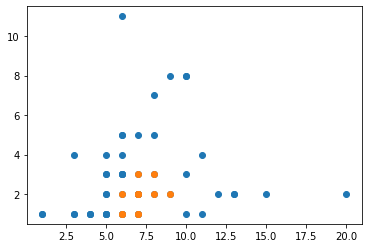

In [140]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_1['#sport venues'],y=cluster_1['#shopping venues'])
plt.show()

#### Cluster 2

In [170]:
cluster_2 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 1, Toronto_merged_sport_shop.columns[1:12]]
cluster_2

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
7,Canada Post Gateway Processing Centre,12,2,M7R,Mississauga,43.636966,-79.615819
8,Cedarbrae,11,2,M1H,Scarborough,43.773136,-79.239476
14,Davisville,14,2,M4S,Central Toronto,43.704324,-79.388790
15,Davisville North,14,1,M4P,Central Toronto,43.712751,-79.390197
21,"Fairview, Henry Farm, Oriole",11,4,M2J,North York,43.778517,-79.346556
25,Glencairn,11,3,M6B,North York,43.709577,-79.445073
42,North Toronto West,13,1,M4R,Central Toronto,43.715383,-79.405678
56,"Summerhill West, Rathnelly, South Hill, Forest...",14,2,M4V,Central Toronto,43.686412,-79.400049
60,Thorncliffe Park,11,1,M4H,East York,43.705369,-79.349372
63,Victoria Village,10,1,M4A,North York,43.725882,-79.315572


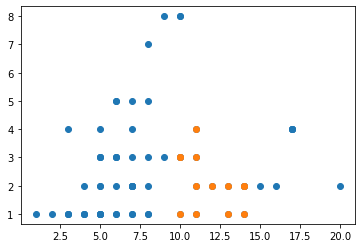

In [171]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_2['#sport venues'],y=cluster_2['#shopping venues'])
plt.show()

#### Cluster 3

In [172]:
cluster_3 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 2, Toronto_merged_sport_shop.columns[1:12]]
cluster_3.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
4,"Birch Cliff, Cliffside West",5,1,M1N,Scarborough,43.692657,-79.264848
13,"Commerce Court, Victoria Hotel",5,2,M5L,Downtown Toronto,43.648198,-79.379817
19,"Dufferin, Dovercourt Village",5,2,M6H,West Toronto,43.669005,-79.442259
20,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",5,1,M9C,Etobicoke,43.643515,-79.577201
27,"Guildwood, Morningside, West Hill",3,1,M1E,Scarborough,43.763573,-79.188711


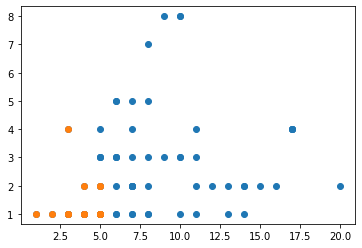

In [173]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_3['#sport venues'],y=cluster_3['#shopping venues'])
plt.show()

#### Cluster 4

In [174]:
cluster_4 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 3, Toronto_merged_sport_shop.columns[1:12]]
cluster_4.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
9,Central Bay Street,10,8,M5G,Downtown Toronto,43.657952,-79.387383
11,Church and Wellesley,8,7,M4Y,Downtown Toronto,43.665860,-79.383160
44,"Queen's Park, Ontario Provincial Government",9,8,M7A,Downtown Toronto,43.662301,-79.389494
62,"University of Toronto, Harbord",10,8,M5S,Downtown Toronto,43.662696,-79.400049


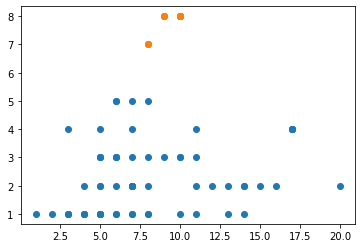

In [175]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_4['#sport venues'],y=cluster_4['#shopping venues'])
plt.show()

#### Cluster 5

In [176]:
cluster_5 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 4, Toronto_merged_sport_shop.columns[1:12]]
cluster_5.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
2,"Bathurst Manor, Wilson Heights, Downsview North",8,1,M3H,North York,43.754328,-79.442259
3,Berczy Park,6,2,M5E,Downtown Toronto,43.644771,-79.373306
6,Business reply mail Processing Centre,7,2,M7Y,East Toronto,43.662744,-79.321558
10,Christie,7,1,M6G,Downtown Toronto,43.669542,-79.422564
16,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",7,1,M6M,York,43.691116,-79.476013


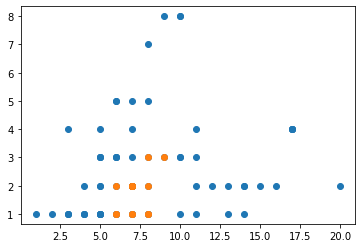

In [177]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_5['#sport venues'],y=cluster_5['#shopping venues'])
plt.show()

#### Cluster 6

In [178]:
cluster_6 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == 5, Toronto_merged_sport_shop.columns[1:12]]
cluster_6.head()

,Neighborhood,#sport venues,#shopping venues,Postalcode,Borough,Latitude,Longitude
18,Downsview,17,4,M3K,North York,43.737473,-79.464763
18,Downsview,17,4,M3L,North York,43.739015,-79.506944
18,Downsview,17,4,M3M,North York,43.728496,-79.495697
18,Downsview,17,4,M3N,North York,43.761631,-79.520999
23,Forest Hill North & West,16,2,M5P,Central Toronto,43.696948,-79.411307


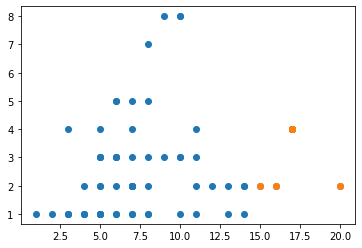

In [179]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_6['#sport venues'],y=cluster_6['#shopping venues'])
plt.show()

#### Cluster 7

In [180]:
cluster_7 = Toronto_merged_sport_shop.loc[Toronto_merged_sport_shop['Cluster Labels'] == , Toronto_merged_sport_shop.columns[1:12]]
cluster_7.head()

SyntaxError: invalid syntax (<ipython-input-180-0f76159f212f>, line 1)

NameError: name 'cluster_7' is not defined

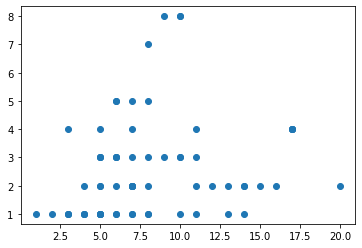

In [181]:
plt.scatter(x=Toronto_merged_sport_shop['#sport venues'],y=Toronto_merged_sport_shop['#shopping venues'])
plt.scatter(x=cluster_7['#sport venues'],y=cluster_7['#shopping venues'])
plt.show()

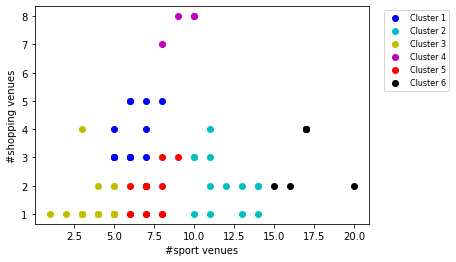

In [182]:
colors = ['b', 'c', 'y', 'm', 'r','k']
a=plt.scatter(x=cluster_1['#sport venues'],y=cluster_1['#shopping venues'],c=colors[0])
b=plt.scatter(x=cluster_2['#sport venues'],y=cluster_2['#shopping venues'],c=colors[1])
c=plt.scatter(x=cluster_3['#sport venues'],y=cluster_3['#shopping venues'],c=colors[2])
d=plt.scatter(x=cluster_4['#sport venues'],y=cluster_4['#shopping venues'],c=colors[3])
e=plt.scatter(x=cluster_5['#sport venues'],y=cluster_5['#shopping venues'],c=colors[4])
f=plt.scatter(x=cluster_6['#sport venues'],y=cluster_6['#shopping venues'],c=colors[5])
plt.xlabel("#sport venues")
plt.ylabel("#shopping venues")
plt.legend((a, b, c, d, e, f),
           ('Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'),
           scatterpoints=1,
           loc='upper right',
           ncol=1,
           fontsize=8,
           bbox_to_anchor=(1.25, 1))